In [1]:
import matplotlib.pyplot as plt
import numpy as np

from dynamics.cart_dynamics import CartDynamics
from dynamics.discretization import Discretization
from dynamics.linearization import Linearization
from function_analysis.function_analysis import FunctionAnalysis
from params import cart_params
from pid_controller.pid_controller import PIDController

In [2]:
params = cart_params()
cart = CartDynamics(params)
lin = Linearization(params)
disc = Discretization(params)
pid = PIDController(Kp=10, Ki=4, Kd=4, dt=params["dt"], min_control=params["min_control"], max_control=params["max_control"])
fa = FunctionAnalysis(params)


# Do linear and nonlinear models match?

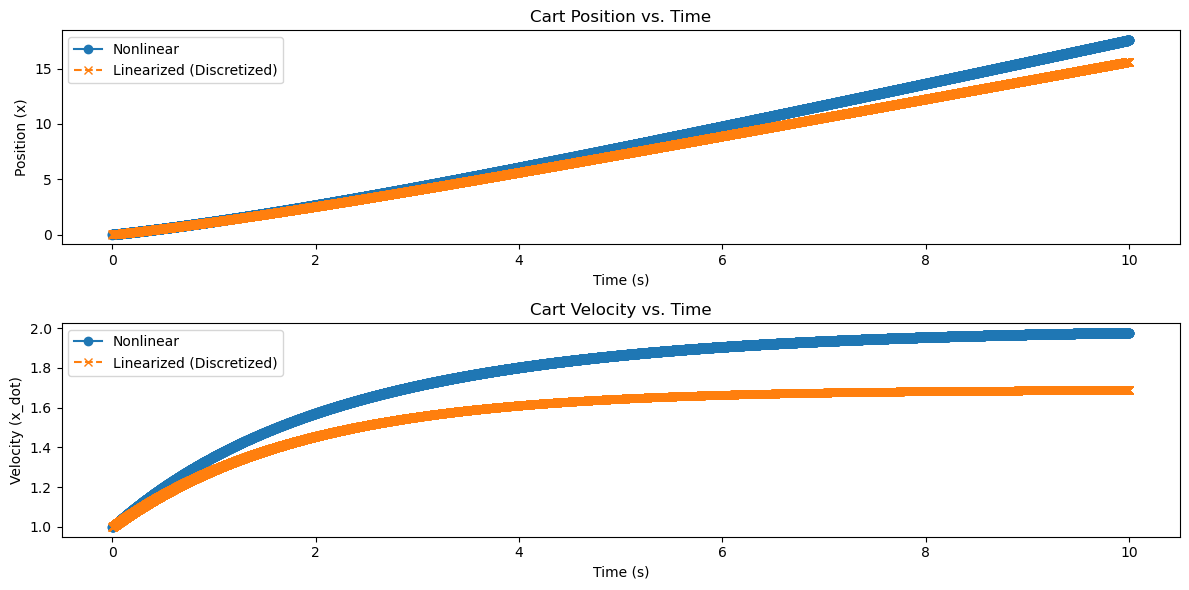

In [3]:
initial_state = np.array([0.0, 1.0])
# Define a constant control input u_k = 1.0 for the nonlinear simulation.
control_current = np.array([1.0])
# For FOH, we now explicitly provide a control slope.
control_slope = np.array([0.5])  # e.g., u changes at 0.5 per second

# Linearize the dynamics at the operating point (here: initial state and control)
A_func, B_func = lin.analytical_jacobians()
A_cont = A_func(initial_state[0], initial_state[1], control_current[0])
B_cont = B_func(initial_state[0], initial_state[1], control_current[0])

# Discretize the dynamics
if params.get("dis_type", "ZOH") == "FOH":
    A_d, B_d0, B_d1 = disc.discretize(A_cont, B_cont)
else:
    A_d, B_d = disc.discretize(A_cont, B_cont)
    B_d0 = B_d
    B_d1 = None

# Set up simulation time vector
dt = params["dt"]
total_time = params["total_time"]
num_steps = int(total_time / dt)
t_vals = np.linspace(0, total_time, num_steps + 1)

# Initialize state history arrays
states_nonlinear = [initial_state.copy()]
states_linear = [initial_state.copy()]

# Set current states for simulation
current_state_nonlinear = initial_state.copy()
current_state_linear = initial_state.copy()

# Simulation loop
for i in range(num_steps):
    # Nonlinear simulation: simulate one dt step using DOP853
    next_state_nonlinear = cart.simulate_nonlinear_step(current_state_nonlinear, control_current, control_slope)

    # Linear simulation:
    if params.get("dis_type", "ZOH") == "FOH":
        # Now explicitly pass control_slope into the linear simulation
        next_state_linear = cart.simulate_linear_step(current_state_linear, control_current, A_d, B_d0, control_slope, B_d_slope=B_d1)
    else:
        next_state_linear = cart.simulate_linear_step(current_state_linear, control_current, A_d, B_d0)

    states_nonlinear.append(next_state_nonlinear)
    states_linear.append(next_state_linear)
    current_state_nonlinear = next_state_nonlinear
    current_state_linear = next_state_linear

states_nonlinear = np.array(states_nonlinear)
states_linear = np.array(states_linear)

# Plot the results: position and velocity over time
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t_vals, states_nonlinear[:, 0], 'o-', label="Nonlinear")
plt.plot(t_vals, states_linear[:, 0], 'x--', label="Linearized (Discretized)")
plt.title("Cart Position vs. Time")
plt.xlabel("Time (s)")
plt.ylabel("Position (x)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_vals, states_nonlinear[:, 1], 'o-', label="Nonlinear")
plt.plot(t_vals, states_linear[:, 1], 'x--', label="Linearized (Discretized)")
plt.title("Cart Velocity vs. Time")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (x_dot)")
plt.legend()

plt.tight_layout()
plt.show()

# Let's design a PID for nonlinear system

final state =  [-0.00843035  0.00421385]


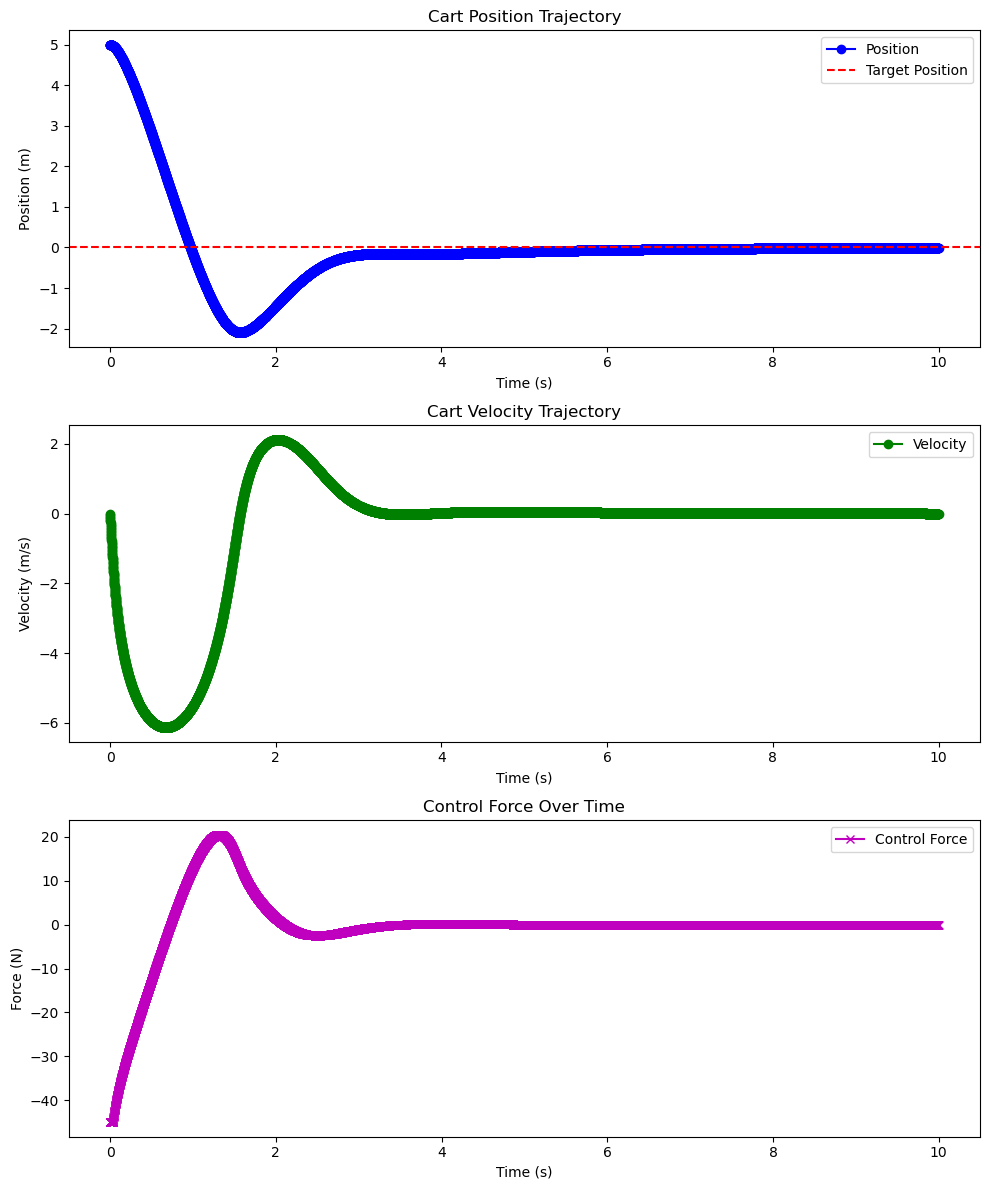

In [4]:
# Simulation time vector
dt = params["dt"]
initial_state = params["initial_state"]
final_state = params["final_state"]
total_time = params["total_time"]
num_steps = int(total_time/dt)
t_vals = np.linspace(0, total_time, num_steps + 1)

# History arrays for plotting
states = [initial_state.copy()]
controls = []

current_state = initial_state.copy()

# --- Simulation Loop ---
for step in range(num_steps):
    # Calculate error using only position (ignore velocity error in the PID formulation)
    error = final_state[0] - current_state[0]
    # Compute the control force via PID
    control_force = pid.compute_control(error)
    control_array = np.array([control_force])
    controls.append(control_force)
    
    # Simulate the cart's dynamics for one time step with the computed control force.
    next_state = cart.simulate_nonlinear_step(current_state, control_array)
    states.append(next_state)
    current_state = next_state.copy()

states = np.array(states)
controls = np.array(controls)
print("final state = ", states[-1])
# --- Plotting Results ---
plt.figure(figsize=(10, 12))

# Plot position over time
plt.subplot(3, 1, 1)
plt.plot(t_vals, states[:, 0], 'b-o', label="Position")
plt.axhline(final_state[0], color='r', linestyle='--', label="Target Position")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.legend()
plt.title("Cart Position Trajectory")

# Plot velocity over time
plt.subplot(3, 1, 2)
plt.plot(t_vals, states[:, 1], 'g-o', label="Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.title("Cart Velocity Trajectory")

# Plot control force over time
plt.subplot(3, 1, 3)
plt.plot(t_vals[:-1], controls, 'm-x', label="Control Force")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.legend()
plt.title("Control Force Over Time")

plt.tight_layout()
plt.show()


# OOOooo we got our nominal trajectory!

In [5]:
nominal_controls = controls
nominal_states = states

print(nominal_controls.shape)
print(nominal_states.shape)

(10000, 1)
(10001, 2)


In [6]:
A_list, B_list = fa.compute_time_varying_jacobians(states, controls)

# Let's see what happens if we deviate from initial state

In [8]:
perturbation = np.array([80, -50])
x_actual_initial = initial_state + perturbation

In [9]:
actual_states = [x_actual_initial.copy()]
current_state = x_actual_initial.copy()
actual_controls = []


# For each time step, compute u_actual by adding some bounded noise to the nominal control.
for i in range(num_steps):
    # Get the nominal control as a numpy array.
    u_nom = np.array([nominal_controls[i]])
    # Add bounded noise (e.g., uniformly between -0.05 and 0.05).
    noise = np.random.uniform(-0.05, 0.05, size=u_nom.shape)
    u_actual = u_nom + noise

    # Save the actual control.
    actual_controls.append(u_actual)
    
    # Compute the next state using the actual control.
    next_state = cart.simulate_nonlinear_step(current_state, u_actual)
    actual_states.append(next_state)
    current_state = next_state.copy()

# Convert lists to numpy arrays.
actual_states = np.array(actual_states)
actual_controls = np.array(actual_controls).reshape(-1,1)
print(actual_states.shape)
print(actual_controls.shape)

(10001, 2)
(10000, 1)


In [10]:
rs = fa.compute_residuals(nominal_states, nominal_controls, actual_states, nominal_controls)

In [34]:
L_A = fa.compute_lipschitz_constant(A_list, t_vals[:-1])
L_B = fa.compute_lipschitz_constant(B_list, t_vals[:-1])
L_r = fa.compute_lipschitz_constant(rs, t_vals[:-1])

print(L_A)
print(L_B)
print(L_r)

print(np.sqrt(L_A**2 + L_B**2 + L_r**2))

KeyboardInterrupt: 

In [11]:
delta_x = actual_states - nominal_states
delta_u = actual_controls - nominal_controls

print(delta_x.shape)
print(delta_u.shape)

(10001, 2)
(10000, 1)


In [12]:
import numpy as np

# Assume these are already defined:
# A_list, B_list, r_list: lists of length N (N = total_time/dt), e.g., N = 1000 for total_time=10 s, dt=0.01 s.
# t_vals: full time vector of length N+1; for transitions, we use:
t_trans = t_vals[:-1]

T_lin = params["T_lin"]    # e.g., 0.2 seconds
dt = params["dt"]          # e.g., 0.01 seconds

# Calculate the number of dt steps per T_lin interval.
segment_length = int(round(T_lin / dt))  # should be exactly 20 if T_lin=0.2 and dt=0.01

# Number of segments: using integer division, discarding any remainder.
num_segments = len(t_trans) // segment_length

# Build segments_indices: each segment is an array of indices with exactly segment_length points.
segments_indices = [np.arange(i * segment_length, (i + 1) * segment_length) 
                    for i in range(num_segments)]

# Partition the lists by slicing:
A_segments = [A_list[i * segment_length:(i + 1) * segment_length] for i in range(num_segments)]
B_segments = [B_list[i * segment_length:(i + 1) * segment_length] for i in range(num_segments)]
r_segments = [rs[i * segment_length:(i + 1) * segment_length] for i in range(num_segments)]
t_segments = [t_trans[i * segment_length:(i + 1) * segment_length] for i in range(num_segments)]

A_lins = [segment[0] for segment in A_segments if len(segment) > 0]
B_lins = [segment[0] for segment in B_segments if len(segment) > 0]
r_lins = [segment[0] for segment in r_segments if len(segment) > 0]

DeltaA_segments = []  # Will be a list of lists, one list per segment
DeltaB_segments = []
Delta_r_segments = []
w_segments = []       # Perturbation term in the dynamics

for seg_idx, seg in enumerate(segments_indices):
    # Use the "nominal" values at the beginning of the segment.
    A_nom = A_lins[seg_idx]
    B_nom = B_lins[seg_idx]
    r_nom = r_lins[seg_idx]
    
    DeltaA_seg = []
    DeltaB_seg = []
    Delta_r_seg = []
    w_seg = []
    
    # Start from the second index so we skip the k_i step.
    for global_idx in seg[1:]:
        # Compute differences:
        DeltaA = A_list[global_idx] - A_nom
        DeltaB = B_list[global_idx] - B_nom
        Delta_r = rs[global_idx] - r_nom
        
        # Store the differences.
        DeltaA_seg.append(DeltaA)
        DeltaB_seg.append(DeltaB)
        Delta_r_seg.append(Delta_r)
        
        # Compute w(k) = DeltaA * delta_x(k) + DeltaB * delta_u(k) + Delta_r
        w_k = DeltaA @ delta_x[global_idx] + DeltaB @ delta_u[global_idx] + Delta_r
        w_seg.append(w_k)
    
    DeltaA_segments.append(DeltaA_seg)
    DeltaB_segments.append(DeltaB_seg)
    Delta_r_segments.append(Delta_r_seg)
    w_segments.append(w_seg)



In [13]:
print("\n--- Checking the Theoretical Prediction ---")
overall_errors = []  # to aggregate error norms

# Loop over each segment (each segment is defined by an array of global indices)
for seg_idx, seg in enumerate(segments_indices):
    # Frozen (nominal) linearization at the beginning of the segment:
    A_nom = A_lins[seg_idx]
    B_nom = B_lins[seg_idx]
    r_nom = r_lins[seg_idx]

    # Skip the first (nominal) index and check only for the remaining indices in the segment
    for pos, global_idx in enumerate(seg[1:-1]):  
        # Compute the differences from the frozen linearization:
        DeltaA = A_list[global_idx] - A_nom
        DeltaB = B_list[global_idx] - B_nom
        Delta_r = rs[global_idx] - r_nom

        # Compute the compensating term w_i(k)
        w_theory = DeltaA @ delta_x[global_idx] + DeltaB @ delta_u[global_idx] + Delta_r

        # The predicted evolution using the frozen linearization plus w:
        prediction = A_nom @ delta_x[global_idx] + B_nom @ delta_u[global_idx] + r_nom + w_theory

        # The actual deviation at the next time step:
        actual_next = delta_x[global_idx + 1]

        # Compute the error (should be near zero)
        error_norm = np.linalg.norm(actual_next - prediction)
        overall_errors.append(error_norm)

overall_mean = np.mean(overall_errors)
overall_max  = np.max(overall_errors)
print("\nOverall:")
print(f"  Mean error = {overall_mean:.3e}")
print(f"  Max error  = {overall_max:.3e}")


--- Checking the Theoretical Prediction ---

Overall:
  Mean error = 4.846e-02
  Max error  = 5.774e-01


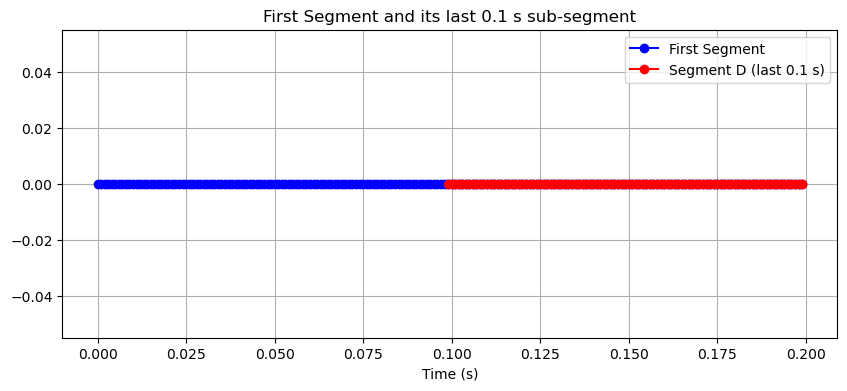

In [14]:
# dt, t_trans, and segments_indices are already defined.
# Here we want to extract, from each segment, the indices corresponding to the last 0.5 seconds.

last_duration = 0.1  # seconds

segment_Ds = []  # this will be a list, one element per segment

for seg in segments_indices:
    seg_times = t_trans[seg]  # times for this segment
    # Check if the segment's duration is at least last_duration:
    if seg_times[-1] - seg_times[0] >= last_duration:
        # Compute the cutoff time (i.e. last 0.5 seconds)
        cutoff = seg_times[-1] - last_duration
        # Create a boolean mask selecting times greater than or equal to the cutoff
        mask = seg_times >= cutoff
        subseg = seg[mask]
    else:
        # If the segment is shorter than last_duration, take the whole segment.
        subseg = seg
    segment_Ds.append(subseg)


# Get the first segment indices and times
first_seg = segments_indices[0]
first_seg_times = t_trans[first_seg]

# Get the sub-segment indices for the first segment and its times
first_seg_D = segment_Ds[0]
first_seg_D_times = t_trans[first_seg_D]

plt.figure(figsize=(10, 4))
plt.plot(first_seg_times, np.zeros_like(first_seg_times), 'bo-', label='First Segment')
plt.plot(first_seg_D_times, np.zeros_like(first_seg_D_times), 'ro-', label='Segment D (last 0.1 s)')
plt.xlabel("Time (s)")
plt.title("First Segment and its last 0.1 s sub-segment")
plt.legend()
plt.grid(True)
plt.show()

Segment 0: Using frozen linearization at index 0
Gain K_i =
[[ -140.32464168 -1013.06700752]]

Segment 1: Using frozen linearization at index 200
Gain K_i =
[[ -169.34434826 -1178.70313543]]

Segment 2: Using frozen linearization at index 400
Gain K_i =
[[ -179.60329688 -1263.10724637]]



/Users/shivashakeri/miniforge3/envs/SCP/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Segment 3: Using frozen linearization at index 600
Gain K_i =
[[-1209.96098346 -2051.272756  ]]

Segment 4: Using frozen linearization at index 800
Gain K_i =
[[ -684.14524742 -1284.36741643]]

Segment 5: Using frozen linearization at index 1000
Gain K_i =
[[ -868.67004357 -1492.78212345]]

Segment 6: Using frozen linearization at index 1200
Gain K_i =
[[ -750.14024384 -1045.20205228]]

Segment 7: Using frozen linearization at index 1400
Gain K_i =
[[-451.60614649 -636.34608407]]

Segment 8: Using frozen linearization at index 1600
Gain K_i =
[[-308.90258041 -431.48460518]]

Segment 9: Using frozen linearization at index 1800
Gain K_i =
[[-392.71083742 -548.98685068]]

Segment 10: Using frozen linearization at index 2000
Gain K_i =
[[-416.23141201 -580.72391214]]

Segment 11: Using frozen linearization at index 2200
Gain K_i =
[[-435.16363278 -610.42380201]]

Segment 12: Using frozen linearization at index 2400
Gain K_i =
[[-354.83521907 -496.07412623]]

Segment 13: Using frozen linear

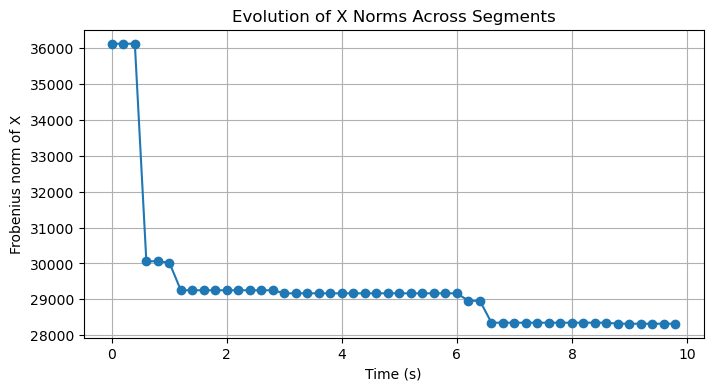

In [15]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

def robust_design_gain(A, B, delta, prev_X=None, verbose=False):
    """
    Robustly design a state-feedback gain K for the discrete-time system
         x_{k+1} = (A+B*K)x_k + r,
    robustly stabilizing the system for all disturbances with ||r|| <= delta.
    
    Uses the change of variables X = P^{-1} > 0 and Y = K*P^{-1}. In addition,
    if a previous X is provided (from the previous segment), it enforces
         X <= prev_X   (i.e. prev_X - X >> 0),
    to capture the shrinking Lyapunov ellipsoid over segments.
    
    Solves the robust LMI:
         minimize   - log_det(X)
         subject to X >> 0,
                    [ X,        (A*X+B*Y)^T ]
                    [ A*X+B*Y,  X - delta^2 I ] >> 0,
                    prev_X - X >> 1e-6 I    (if prev_X is provided)
    
    Returns:
      K, X_val, Y_val
    """
    n = A.shape[0]
    m = B.shape[1]
    
    # Decision variables.
    X = cp.Variable((n, n), symmetric=True)
    Y = cp.Variable((m, n))
    
    # Define the robust LMI block.
    AXBY = A @ X + B @ Y
    M_robust = cp.bmat([
        [X,             AXBY.T],
        [AXBY,          X - delta**2 * np.eye(n)]
    ])
    
    constraints = [
        X >> 1e-6 * np.eye(n),           # X positive definite.
        M_robust >> 1e-6 * np.eye(2*n)     # Robust LMI condition.
    ]
    if prev_X is not None:
        # Enforce that the new X is "smaller" than the previous one.
        constraints.append(prev_X - X >> 0 * np.eye(n))
    
    # Objective: maximize logdet(X) <=> minimize -logdet(X)
    objective = cp.Minimize(-cp.log_det(X))
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, verbose=verbose)
    
    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError("The optimization did not converge.")
    
    X_val = X.value
    Y_val = Y.value
    K = Y_val @ np.linalg.inv(X_val)
    
    return K, X_val, Y_val

def simulate_closed_loop_segments_with_X(initial_state, nominal_states, nominal_controls, 
                                         segments_indices, A_list, B_list, cart, design_gain_func,
                                         t_trans, delta):
    """
    Simulate the closed-loop system over the time horizon by dividing it into segments.
    In each segment, a robust state-feedback gain K_i is designed using the frozen linearization
    (A_i, B_i) at the segment start. The design uses a robust LMI that incorporates a disturbance
    bound delta and enforces that X is monotonically decreasing (in the LMI sense) from segment to segment.
    
    At each time step, the actual control is computed as:
         u_actual(k) = u_nominal(k) + K_i * (x_actual(k) - x_nominal(k))
    
    In addition, this function records the Frobenius norm of the optimal X for each segment.
    
    Returns:
       actual_states : np.array of shape (N+1, n)
       actual_controls : np.array of shape (N, m)
       X_norms : np.array (one per segment)
       segment_times : np.array (times corresponding to the start of each segment)
    """
    actual_states = [initial_state.copy()]
    actual_controls = []
    X_norms = []      # store the Frobenius norm of X for each segment
    X = []
    segment_times = []  # record the start time of each segment
    
    prev_X = None  # For the first segment, no previous X constraint.
    
    # Loop over segments.
    for seg_idx, seg in enumerate(segments_indices):
        start_index = seg[0]
        A_i = A_list[start_index]
        B_i = B_list[start_index]
        
        # Design gain for this segment.
        K_i, X_i, _ = design_gain_func(A_i, B_i, delta, prev_X, verbose=False)
        # Save current X as previous for the next segment.
        prev_X = X_i
        
        X_norms.append(np.linalg.norm(X_i, 'fro'))
        X.append(X_i)
        segment_times.append(t_trans[start_index])
        
        print(f"Segment {seg_idx}: Using frozen linearization at index {start_index}")
        print(f"Gain K_i =\n{K_i}\n")
        
        # For each time step in this segment, apply the closed-loop law.
        for idx in seg:
            current_state = actual_states[-1]
            delta_x = current_state - nominal_states[idx]
            u_nom = nominal_controls[idx]
            u_act = u_nom + K_i @ delta_x
            actual_controls.append(u_act)
            
            # Simulate one step of nonlinear dynamics.
            next_state = cart.simulate_nonlinear_step(current_state, u_act)
            actual_states.append(next_state)
    
    return (np.array(actual_states), 
            np.array(actual_controls), 
            np.array(X_norms), 
            np.array(segment_times),
            np.array(X))

# === Example: Plotting X Norms Over Time ===
# (Assume that the following variables are defined from your simulation setup:
#  x_actual_initial, nominal_states, nominal_controls, segments_indices, A_list, B_list, cart, t_trans.)

# Set the residual/disturbance bound (delta) reflecting the robustness level.
delta = 0.05   # adjust as needed

# Simulate the closed-loop trajectory using the robust gain design with chained X constraints.
actual_states, actual_controls, X_norms, segment_times, X = simulate_closed_loop_segments_with_X(
    x_actual_initial,
    nominal_states,
    nominal_controls,
    segments_indices,
    A_list,
    B_list,
    cart,
    design_gain_func=robust_design_gain,
    t_trans=t_trans,
    delta=delta
)

# Plot the Frobenius norms of X over the segment start times.
plt.figure(figsize=(8,4))
plt.plot(segment_times, X_norms, marker='o', linestyle='-')
plt.xlabel("Time (s)")
plt.ylabel("Frobenius norm of X")
plt.title("Evolution of X Norms Across Segments")
plt.grid(True)
plt.show()

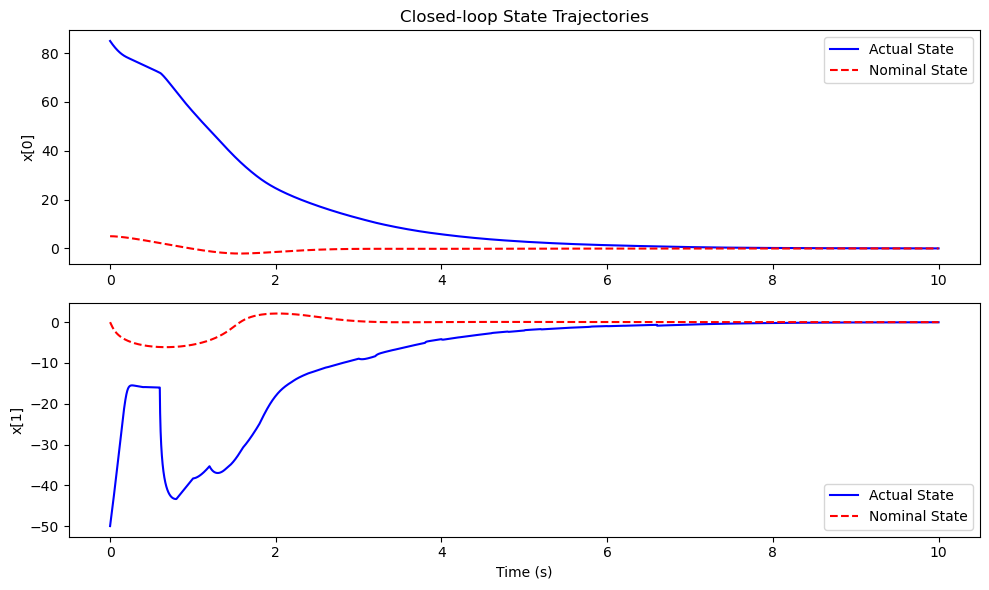

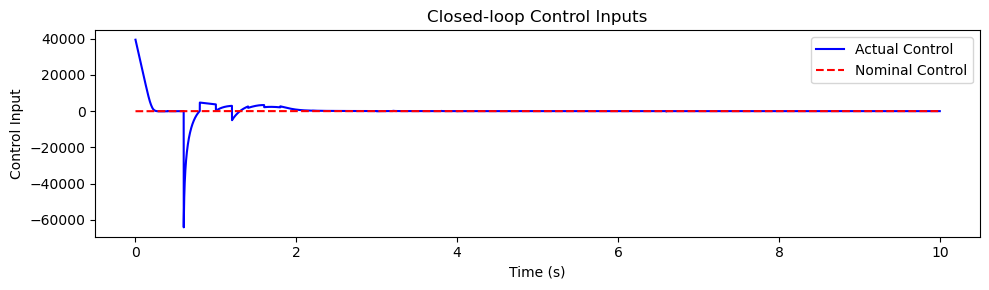

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming dt and total_time are defined in your parameters:
dt = params["dt"]         
total_time = t_vals[-1]

# Create time vectors for states and controls:
t_states = t_vals  # already length N+1
t_controls = t_vals[:-1]  # assuming controls are applied at the beginning of each step

# Number of state variables (n) and control variables (m)
n_states = actual_states.shape[1]
n_controls = actual_controls.shape[1]

# --- Plot the state trajectories ---
plt.figure(figsize=(10, 6))
for i in range(n_states):
    plt.subplot(n_states, 1, i+1)
    plt.plot(t_states, actual_states[:, i], 'b-', label='Actual State')
    plt.plot(t_states, nominal_states[:len(t_states), i], 'r--', label='Nominal State')
    plt.ylabel(f"x[{i}]")
    if i == 0:
        plt.title("Closed-loop State Trajectories")
    if i == n_states - 1:
        plt.xlabel("Time (s)")
    plt.legend(loc='best')
plt.tight_layout()
plt.show()

# --- Plot the control inputs ---
plt.figure(figsize=(10, 3))
for j in range(n_controls):
    plt.plot(t_controls, actual_controls[:, j], 'b-', label='Actual Control')
    plt.plot(t_controls, nominal_controls[:len(t_controls), j], 'r--', label='Nominal Control')
plt.xlabel("Time (s)")
plt.ylabel("Control Input")
plt.title("Closed-loop Control Inputs")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

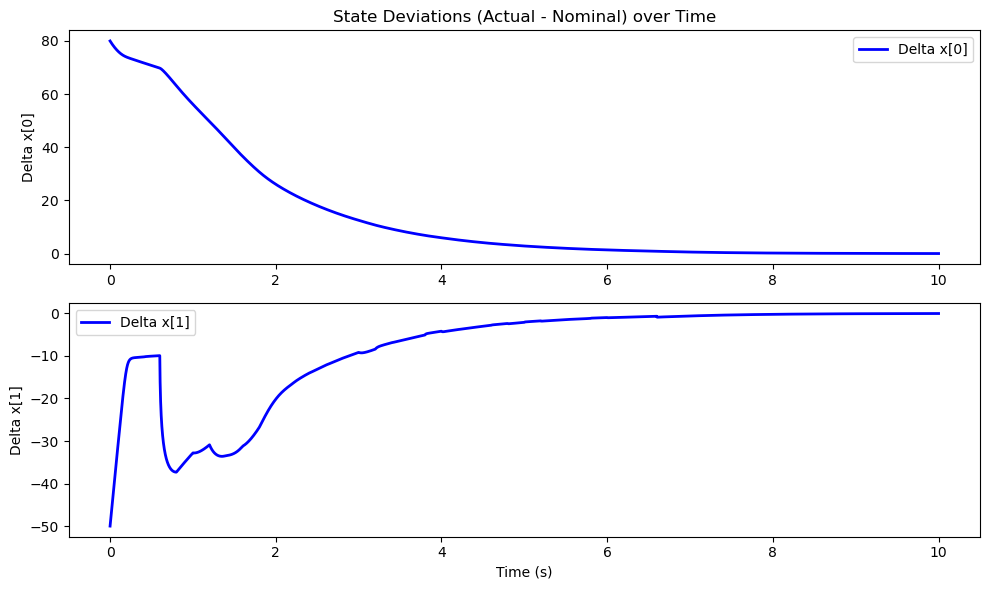

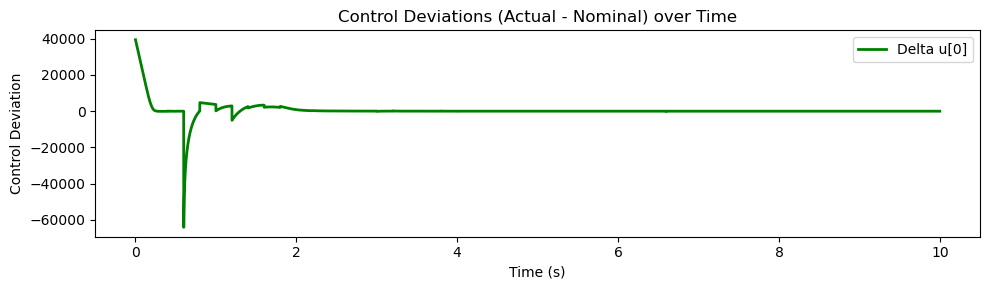

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Assume that actual_states, nominal_states, actual_controls, nominal_controls, and t_vals are defined.
# actual_states: (N+1, n), nominal_states: (N+1, n)
# actual_controls: (N, m), nominal_controls: (N, m)
# t_vals: time vector for states (length N+1)

# Compute the state deviations:
delta_states = actual_states - nominal_states[:len(actual_states)]
# Compute the control deviations:
delta_controls = actual_controls - nominal_controls[:len(actual_controls)]

# Create time vectors:
t_states = t_vals  # for state deviations (length N+1)
t_controls = t_vals[:-1]  # for control deviations (length N)

# --- Plot state deviations ---
n_states = delta_states.shape[1]
plt.figure(figsize=(10, 6))
for i in range(n_states):
    plt.subplot(n_states, 1, i+1)
    plt.plot(t_states, delta_states[:, i], 'b-', linewidth=2, label=f'Delta x[{i}]')
    plt.ylabel(f'Delta x[{i}]')
    if i == 0:
        plt.title("State Deviations (Actual - Nominal) over Time")
    if i == n_states - 1:
        plt.xlabel("Time (s)")
    plt.legend(loc='best')
plt.tight_layout()
plt.show()

# --- Plot control deviations ---
n_controls = delta_controls.shape[1]
plt.figure(figsize=(10, 3))
for j in range(n_controls):
    plt.plot(t_controls, delta_controls[:, j], 'g-', linewidth=2, label=f'Delta u[{j}]')
plt.xlabel("Time (s)")
plt.ylabel("Control Deviation")
plt.title("Control Deviations (Actual - Nominal) over Time")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [18]:
def plot_ellipsoidal_bounds_all(segment_times, X_list, nominal_states, dt, actual_states=None, actual_time=None):
    """
    Plot, for each state variable, the ellipsoidal bound computed from X (optimal X from the LMI)
    at the start of each segment, along with the nominal trajectory and, optionally, the actual trajectory.

    The bound for coordinate i is defined as:
       r_i = 1/sqrt(e_i^T X^{-1} e_i)
    where X is the optimal X matrix (X = P^{-1}) from the LMI design.

    Parameters:
      segment_times : array_like, shape (N_seg,)
          Times corresponding to the start of each segment.
      X_list : list of np.arrays, each of shape (n,n)
          The optimal X matrices from the LMI for each segment.
      nominal_states : np.array, shape (T, n)
          The nominal trajectory (e.g., obtained via PID).
      dt : float
          The simulation time step.
      actual_states : np.array, shape (T_actual, n), optional
          The actual trajectory. If provided, it will be overlaid.
      actual_time : array_like, shape (T_actual,), optional
          The time vector for the actual trajectory. If not provided and actual_states
          is given, it is computed as np.arange(0, len(actual_states)*dt, dt).
    """
    n = nominal_states.shape[1]
    segment_times = np.array(segment_times)
    
    # Compute per-coordinate bounds for each segment using the X matrices.
    bounds = np.zeros((len(segment_times), n))
    nominal_seg_states = np.zeros((len(segment_times), n))
    
    for i, t in enumerate(segment_times):
        # Get the X matrix for this segment.
        X = X_list[i]
        # Compute X_inv = P = X^{-1}
        X_inv = np.linalg.inv(X)
        for state_idx in range(n):
            e = np.zeros((n,))
            e[state_idx] = 1.0
            # Bound in the i-th direction.
            bounds[i, state_idx] = 1 / np.sqrt(e.T @ X_inv @ e)
            # Record the nominal state at the segment start.
            idx = int(round(t / dt))
            idx = min(idx, nominal_states.shape[0] - 1)
            nominal_seg_states[i, state_idx] = nominal_states[idx, state_idx]
    
    # For the first segment, print the lower and upper bound sizes for each state.
    if len(segment_times) > 0:
        print("First segment ellipsoidal bounds:")
        for state_idx in range(n):
            lower = nominal_seg_states[0, state_idx] - bounds[0, state_idx]
            upper = nominal_seg_states[0, state_idx] + bounds[0, state_idx]
            print(f" State {state_idx}: Lower bound = {lower:.4f}, Upper bound = {upper:.4f}")

    # If actual_states are provided, compute its time vector.
    if actual_states is not None:
        if actual_time is None:
            actual_time = np.arange(0, actual_states.shape[0] * dt, dt)
    
    # Create subplots for each state.
    fig, axes = plt.subplots(n, 1, figsize=(10, 3*n), sharex=True)
    
    for state_idx in range(n):
        ax = axes[state_idx] if n > 1 else axes
        
        # Plot nominal segment start states.
        ax.plot(segment_times, nominal_seg_states[:, state_idx], 'b.-', markersize=8, label=f'Nominal State {state_idx}')
        # Compute the upper and lower bounds.
        upper = nominal_seg_states[:, state_idx] + bounds[:, state_idx]
        lower = nominal_seg_states[:, state_idx] - bounds[:, state_idx]
        ax.fill_between(segment_times, lower, upper, color='red', alpha=0.3, label='Ellipsoidal Bound')
        
        # If actual trajectory is provided, overlay it.
        if actual_states is not None:
            ax.plot(actual_time, actual_states[:, state_idx], 'k-', linewidth=1.5, label=f'Actual State {state_idx}')
        
        ax.set_ylabel(f"State {state_idx}")
        ax.legend()
    
    axes[-1].set_xlabel("Time (s)")
    plt.suptitle("Nominal Trajectory with Ellipsoidal Bounds and Actual Trajectory")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

First segment ellipsoidal bounds:
 State 0: Lower bound = -149.4186, Upper bound = 159.4186
 State 1: Lower bound = -161.2351, Upper bound = 161.2351


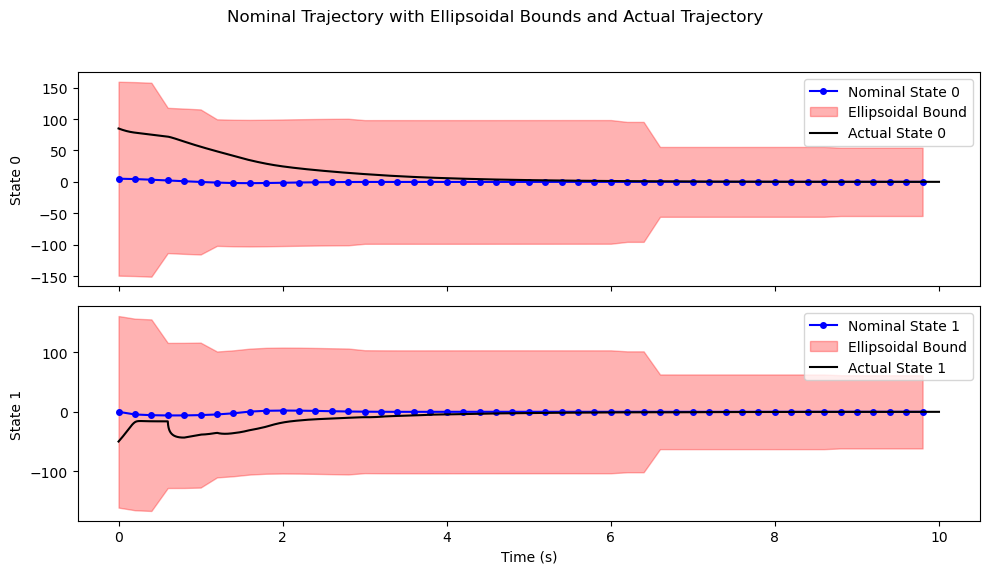

In [19]:
plot_ellipsoidal_bounds_all(segment_times, X, nominal_states, dt, actual_states=actual_states)